In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus, graphviz, time
import shap

from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid
from sklearn import preprocessing, linear_model, ensemble, svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from IPython.display import Image, display

Let's load the data and take a look at the first observations.

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Features Descritpion :
1. Age
2. Sex
3. cp : Chest Pain Type : 
        -- Value 1: typical angina 
        -- Value 2: atypical angina 
        -- Value 3: non-anginal pain 
        -- Value 4: asymptomatic 
4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
5. chol : serum cholestoral in mg/dl
6. fbs : fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg : resting electrocardiographic results 
        -- Value 0: normal 
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST
           elevation or depression of > 0.05 mV) 
        -- Value 2: showing probable or definite left ventricular hypertrophy
           by Estes' criteria 
8. thalach : maximum heart rate achieved during exercise
9. exang : exercise induced angina (1 = yes; 0 = no)
10. oldpeak : ST depression induced by exercise relative to rest
11. slope : the slope of the peak exercise ST segment 
        -- Value 1: upsloping 
        -- Value 2: flat 
        -- Value 3: downsloping
12. ca : number of major vessels (0-3) colored by flourosopy 
13. thal : thallium heart scan 
        -- 1 = normal 
        -- 2 = fixed defect
        -- 3 = reversable defect
        
Predicted feature :
14. target : diagnosis of heart disease (angiographic disease status) 
        -- Value 0: < 50% diameter narrowing 
        -- Value 1: > 50% diameter narrowing 

Since we are working with life threatening medical conditions, we want to avoid false negatives as much as possible. **We will thus focus on maximizing the recall score of our models.**

Let's check for class imbalance, something common in health related datasets.

In [3]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

Since there is no big imbalance let's go ahead and try a first weak learner to get an idea of the important features.
We start by converting the categorical data to dummies and creating a train and test split.

In [4]:
df.cp = df.cp.astype(str)
df.restecg = df.restecg.astype(str)
df.slope = df.slope.astype(str)
df.thal = df.thal.astype(str)
df.ca = df.ca.astype(str)

X = df.drop(columns='target')
X = pd.get_dummies(X)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

We now fit a weak tree classifier to look at some of the important features and use it as a baseline

--- 0.0029914379119873047 seconds ---


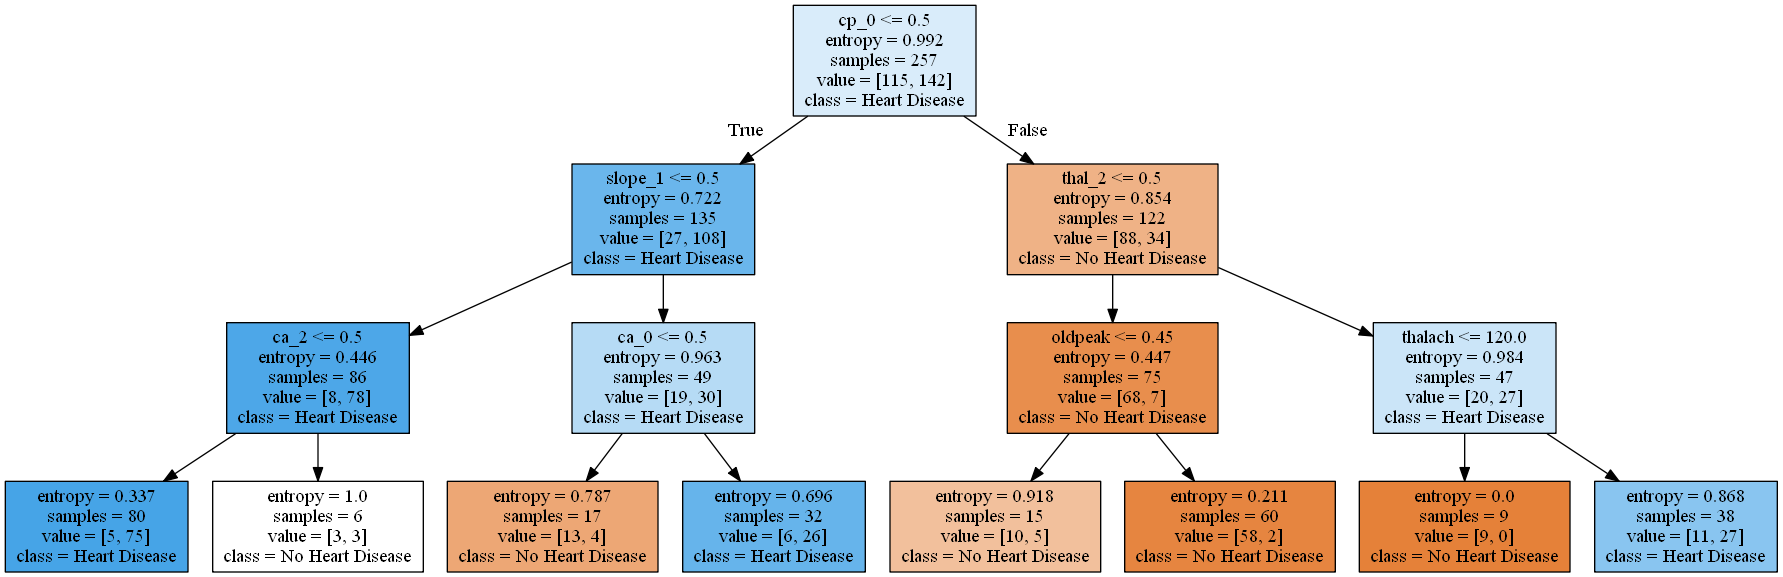

In [5]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=5,
    max_depth=3,
)

start_time = time.time()
decision_tree.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write('Images/weak_tree.png', format='png')
Image(graph.create_png())

In [6]:
np.mean(cross_val_score(decision_tree, X, y, cv=10, scoring='recall'))

0.8238970588235294

It seems that the results of the thallium heart scan as well as chest pain absence and umber of major vessels colored by flourosopy are important features.
Let's also add a couple more features based on intuition (old age, high blood pressure, high cholesterol).

In [7]:
df['old'] = np.where(df['age']>=56.6, 1, 0)
df['young'] = np.where(df['age']<=40, 1, 0)
df['high_col'] = np.where(df.chol >= 250, 1, 0)
df['high_bps'] = np.where(df.trestbps >= 130, 1, 0)
df['young_high_bps'] = np.where((df.trestbps <= 140) & (df.age <= 45), 1, 0)
df['chest_pain'] = np.where(df.cp != '0', 1, 0)
df.sex = np.where(df.sex == 1, 'male', 'female')
df['sex_slope'] = df['sex'] + '_' + df['slope'].astype(str)

We create a new set of train and test splits with the newly engineered features and look at the first observations for these new features.

In [8]:
X = df.drop(columns='target')
X = pd.get_dummies(X)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [9]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
X.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,old,young,high_col,high_bps,young_high_bps,chest_pain,sex_female,sex_male,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,sex_slope_female_0,sex_slope_female_1,sex_slope_female_2,sex_slope_male_0,sex_slope_male_1,sex_slope_male_2
0,63,145,233,1,150,0,2.3,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,0,1,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,41,130,204,0,172,0,1.4,0,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,56,120,236,0,178,0,0.8,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,57,120,354,0,163,1,0.6,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


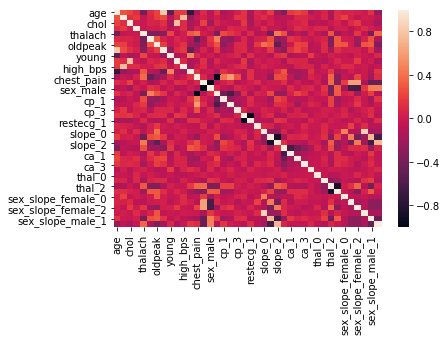

In [10]:
sns.heatmap(X.corr())

Looking at the correlation heatmap, it seems like we do not have colinearity issues in our features.

Now let's define our grid search models and parameters.

In [11]:
classifiers = {'knn' : KNeighborsClassifier, 
               'forest' : ensemble.RandomForestClassifier,
               'logregr' : linear_model.LogisticRegression,
               'ridge' : linear_model.RidgeClassifier,
               'svc' : svm.SVC,
               'boosting' : ensemble.GradientBoostingClassifier
              }

clf_grid = {'knn' : {'n_neighbors' : [1, 5, 10, 15], 
                     'weights' : ['uniform', 'distance'],
                     'algorithm' : ['ball_tree', 'kd_tree', 'brute']},
            'forest' : {'n_estimators' : [100, 500, 1000],
                        'criterion' : ['gini', 'entropy'], 
                        'max_depth' : [2, 5, 10]},
            'logregr' : {'penalty' : ['l1', 'l2'], 
                         'tol' : [1e-3, 1e-4, 1e-5], 
                         'C' : [1, 1e-2, 1e-4], 
                         'solver' : ['liblinear']},
            'ridge' : {'alpha' : [1, 100, 1000], 
                       'tol' : [1e-3, 1e-4, 1e-5], 
                       'solver' : ['svd', 'cholesky', 'lsqr']}, #, ‘sparse_cg’, ‘sag’, ‘saga’,
            'svc' : {'C' : [1, 1e-2, 1e-3], 
                     'kernel' : ['linear', 'rbf'],  #, 'poly'
                     'gamma' : ['auto']},
            'boosting' : {'n_estimators': [100, 500, 1000],
                          'max_depth': [2, 3, 4],
                          'loss': ['deviance', 'exponential'],
                          'subsample' : [0.4, 0.8, 1]}
           }

In [12]:
def grid_search(X_train, X_test, y_train, y_test):
    results = pd.DataFrame()
    for method in classifiers.keys():
        classifier, parameters = classifiers[method](), clf_grid[method]
        for parameter_set in ParameterGrid(parameters):
            start_time = time.time()
            print('{} {}'.format(method, list(parameter_set.values())[:]))
            
            classifier.set_params(**parameter_set)
            classifier.fit(X_train, y_train.values.ravel())
            y_pred = classifier.predict(X_test)
            
            if (method == 'ridge') or (method == 'svc'):
                #d = classifier.decision_function(X_test)[0]
                #y_prob = np.exp(d) / np.sum(np.exp(d))
                Auroc = 0.5
            else:
                y_prob = classifier.predict_proba(X_test)[:,1]
                Auroc = roc_auc_score(y_test, y_prob)
                
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            Accuracy = accuracy_score(y_test, y_pred)
            Precision = precision_score(y_test, y_pred)
            Recall = recall_score(y_test, y_pred)
        
            df2 = pd.DataFrame([(method, parameter_set.values(), Accuracy, Precision, Recall, Auroc, fn, fp)], 
                           columns = ['Method' , 'Parameters', 'Accuracy', 'Precision' , 
                                      'Recall', 'Auroc', 'False negative', 'False positive'])
            results = results.append(df2, ignore_index=True)
            
            total_time = time.time() - start_time
            print('Done in {} seconds'.format(total_time))
        
    return results

We now run our gridsearch on our splits 

In [13]:
results =  grid_search(X_train, X_test, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.013962745666503906 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.013957023620605469 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.01196432113647461 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.01495814323425293 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.01495981216430664 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.016959190368652344 seconds
knn ['ball_tree', 15, 'uniform']
Done in 0.013957023620605469 seconds
knn ['ball_tree', 15, 'distance']
Done in 0.014959096908569336 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.013962268829345703 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.015958309173583984 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.013968229293823242 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.013962030410766602 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.015958547592163086 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.013962268829345703 seconds
knn ['kd_tree', 15, 'uniform']
Done 

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.01495981216430664 seconds
logregr [0.0001, 'l1', 'liblinear', 0.0001]


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.013962745666503906 seconds
logregr [0.0001, 'l1', 'liblinear', 1e-05]


C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Done in 0.013964414596557617 seconds
logregr [0.0001, 'l2', 'liblinear', 0.001]
Done in 0.014960289001464844 seconds
logregr [0.0001, 'l2', 'liblinear', 0.0001]
Done in 0.01196742057800293 seconds
logregr [0.0001, 'l2', 'liblinear', 1e-05]
Done in 0.013963937759399414 seconds
ridge [1, 'svd', 0.001]
Done in 0.019946813583374023 seconds
ridge [1, 'svd', 0.0001]
Done in 0.01795029640197754 seconds
ridge [1, 'svd', 1e-05]
Done in 0.010971307754516602 seconds
ridge [1, 'cholesky', 0.001]
Done in 0.010969161987304688 seconds
ridge [1, 'cholesky', 0.0001]
Done in 0.01695394515991211 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.009973764419555664 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.01196742057800293 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.01894855499267578 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.013972759246826172 seconds
ridge [100, 'svd', 0.001]
Done in 0.011964559555053711 seconds
ridge [100, 'svd', 0.0001]
Done in 0.012960672378540039 seconds
ridge [100, 'svd', 1e-05]
Done

In [14]:
results.groupby('Method').mean()

,Accuracy,Precision,Recall,Auroc,False negative,False positive
Method,,,,,,
boosting,0.852155,0.851276,0.859618,0.935763,4.351852,4.666667
forest,0.893443,0.868421,0.931900,0.966338,2.111111,4.388889
knn,0.633197,0.620032,0.750000,0.670766,7.750000,14.625000
logregr,0.744080,0.650772,0.697133,0.802270,9.388889,6.222222
ridge,0.867638,0.853578,0.891278,0.500000,3.370370,4.703704
svc,0.683060,0.675951,0.924731,0.500000,2.333333,17.000000


By grouping each model we can easily compare what models seem to be doing better in our case.
Boosting and random forest seem to give teh best recall scores without impeding too much on Precision, unlike SVC.

We now rank individual models and parameters by Recall since this is the metric we are interested in.

In [15]:
results.sort_values(by='Recall', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc,False negative,False positive
88,svc,"(1, auto, rbf)",0.573770,0.543860,1.000000,0.500000,0,26
92,svc,"(0.001, auto, rbf)",0.508197,0.508197,1.000000,0.500000,0,30
90,svc,"(0.01, auto, rbf)",0.508197,0.508197,1.000000,0.500000,0,30
73,ridge,"(100, cholesky, 0.0001)",0.901639,0.878788,0.935484,0.500000,2,4
60,ridge,"(1, svd, 0.001)",0.901639,0.878788,0.935484,0.500000,2,4
36,forest,"(entropy, 5, 100)",0.918033,0.906250,0.935484,0.968817,2,3
37,forest,"(entropy, 5, 500)",0.885246,0.852941,0.935484,0.968817,2,5
38,forest,"(entropy, 5, 1000)",0.885246,0.852941,0.935484,0.970968,2,5
40,forest,"(entropy, 10, 500)",0.901639,0.878788,0.935484,0.970968,2,4
41,forest,"(entropy, 10, 1000)",0.901639,0.878788,0.935484,0.967742,2,4


We can now select our "best" model. And even if some have perfect recall, they have terrible precision.
We want to avoid that since sending too many healthy patients to take the angiographic test could be problematic for hospitals in terms of money and time.

We will run the selected model through cross validation to avoid overfitting.

In [16]:
best = ensemble.RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=2)

np.mean(cross_val_score(best, X, y, cv=10, scoring='recall'))

0.8963235294117646

The selected test seem to be doing good in the recall score, let's also check the ROC curve for our model on the test and train set.

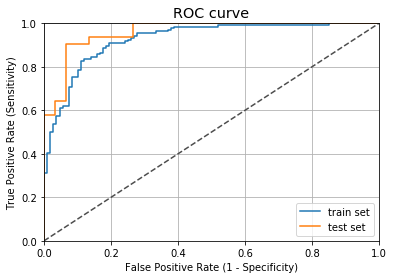

In [17]:
best.fit(X_train,y_train)
y_pred_quant = best.predict_proba(X_train)[:, 1]
y_pred_quant_2 = best.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_quant)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_pred_quant_2)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot(fpr_2, tpr_2)
ax.legend(['train set', 'test set'])


ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Our model seem to be doing great. But what can it tell us about our data and how can it help health professionals aside from predicting who to send for a coronary angiography.

Let's use the SHAP method to delve into our features' explanatory power.

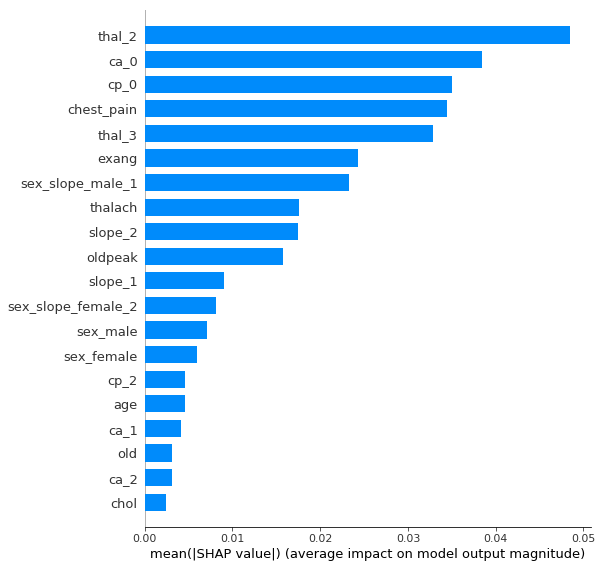

In [40]:
explainer = shap.TreeExplainer(best)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

It seems like chest pain absence and thallium test results have the biggest impact on the decision from our model. Fluoroscopy results (ca) seem important as well.

Let's check how they impact the decision.

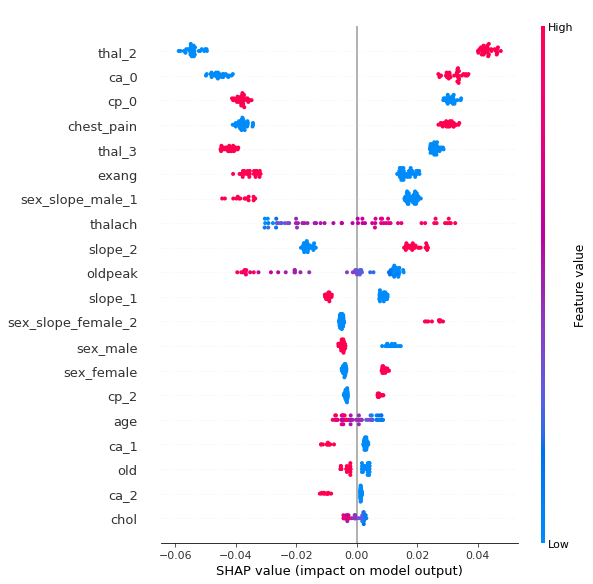

In [41]:
shap.summary_plot(shap_values[1], X_test)

The absence of chest pain (`cp_0=1`) strongly indicates against heart disease, same as a thallium result of reversible defect (`thal_3=1`). A thallium result of fixed defect (`thal_2=1`) strongly indicates for heart disease as well as the presence of any chest pain (`chest_pain=1`) and zero major vessel colored by fluoroscopy (`ca_0=1`) which would make sense since it would indicate the vessels are clogged.

In [46]:
shap.initjs()
shap_values_patient = explainer.shap_values(X_test.iloc[2,:].astype(float))
shap.force_plot(explainer.expected_value[1], shap_values_patient[1], X_test.iloc[1,:].astype(float))

In [47]:
shap_values = explainer.shap_values(X_test.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

Let's explore now what test have the better return on investment.
We will use the following prices in Canadian Dollars (from the UCI database) as guideline :

    -- age: 1.00
    -- sex: 1.00
    -- cp: 1.00
    -- trestbps: 1.00
    -- chol: 7.27
    -- fbs: 5.20
    -- restecg: 15.50
    -- thalach: 102.90
    -- exang: 87.30
    -- oldpeak: 87.30
    -- slope: 87.30
    -- ca: 100.90
    -- thal: 102.90

Tests with the same price are performed together, meaning you only have to pay 87.30 CAD once to acces exang, oldpeak and slope values for the patient.

Let's try to run our model by stripping every feature except the 'free' ones (age, sex, chest pain and trestbps) and only adding the reults of the most expensive test, the thallium heart scan, that we previously identified as the one of the most important features.

In [22]:
X_min = X[['age', 'trestbps', 'sex_male', 'sex_female', 'chest_pain', 'cp_0', 
           'cp_1', 'cp_2', 'cp_3', 'thalach', 'thal_0', 'thal_1', 'thal_2', 'thal_3']]

In [23]:
np.mean(cross_val_score(best, X_min, y, cv=10, scoring='recall'))

0.9139705882352942

In [34]:
np.mean(cross_val_score(best, X_min, y, cv=10, scoring='precision'))

0.7804188054807251

This set of features seems to be doing even better than with all the features ! This tends to show that the only needed test could really well be the thallium heart scan. It shows that to make an informed decision it seems to be enough to predict heart disease without false negatives.

Let's try to use only the 'free' observations to make a decision :

In [24]:
X_min_2 = X[['age', 'trestbps', 'sex_male', 'sex_female', 'chest_pain', 'cp_0', 'cp_1', 'cp_2', 'cp_3']]

In [25]:
np.mean(cross_val_score(best, X_min_2, y, cv=10, scoring='recall'))

0.7628676470588235

In [35]:
np.mean(cross_val_score(best, X_min_2, y, cv=10, scoring='precision'))

0.7906737431814831

As expected, This does not seem to be enough information to predict heart disease properly, although it does better than a random guess solely based on presence or absence of chest pain.

We can try adding the cheaper tests (chol, fbs, restecg) for 27.97 CAD :

In [26]:
X_min_3 = X[['age', 'trestbps', 'sex_male', 'sex_female', 'chest_pain', 'cp_0', 'cp_1', 'cp_2', 'cp_3',
            'chol', 'fbs', 'restecg_0', 'restecg_1', 'restecg_2']]

In [27]:
np.mean(cross_val_score(best, X_min_3, y, cv=10, scoring='recall'))

0.7628676470588235

In [36]:
np.mean(cross_val_score(best, X_min_3, y, cv=10, scoring='precision'))

0.7906737431814831

Adding these tests adds nothing of value to the prediction of heart disease.

Let's add more expensive tests (exang, oldpeak, slope) for 87.30 CAD :

In [28]:
X_min_4 = X[['age', 'trestbps', 'sex_male', 'sex_female', 'chest_pain', 'cp_0', 'cp_1', 'cp_2', 'cp_3',
            'exang', 'oldpeak', 'slope_0', 'slope_1', 'slope_2']]

In [29]:
np.mean(cross_val_score(best, X_min_4, y, cv=10, scoring='recall'))

0.8360294117647058

In [37]:
np.mean(cross_val_score(best, X_min_4, y, cv=10, scoring='precision'))

0.7693550665880388

This improved the prediction of our model significantly but still does poorly compared to our model with only the results of the thallium heart scan.

Finally, let's try a model with the second most expensive test of blood vessel fluoroscopy (ca) for 100.90 CAD :

In [30]:
X_min_5 = X[['age', 'trestbps', 'sex_male', 'sex_female', 'chest_pain', 'cp_0', 'cp_1', 'cp_2', 'cp_3',
            'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4']]

In [31]:
np.mean(cross_val_score(best, X_min_5, y, cv=10, scoring='recall'))

0.8183823529411764

In [38]:
np.mean(cross_val_score(best, X_min_5, y, cv=10, scoring='precision'))

0.7797766475011058

This is barely any improvement over our last model.

Based on  those results, it seems that the only test that gives a good prediction using our model is the thallium heart scan. It is the most expensive but not by far. All in all it offers the best return on investment when trying to detect heart disease without undergoing a coronary angiography and helps the decision to send a patient for one more than any other test.